In [1]:
import sys
sys.path.append('./src')

import typing as tp
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm

from measure_blur_strength import main
from metrics import ssim, psnr
from imutils import imsshow, load_npy, imread, srgb2gray, center_crop, imshow
from data.convolution import convolve
from data.convertation import srgbf_to_linrgbf, uint8_to_float32
from data.generate.gauss_blur import generate_gauss_kernel
from deconv.classic.wiener.wiener import wiener_gray

plt.gray()

<Figure size 640x480 with 0 Axes>

## 1 Эксперимент (метрики между исходным и размытым изображениями)

In [2]:
def pad_to_shape(a, shape):
    y_, x_ = shape
    y, x = a.shape
    y_pad = (y_-y)
    x_pad = (x_-x)
    return np.pad(a,((y_pad//2, y_pad//2 + y_pad%2), 
                     (x_pad//2, x_pad//2 + x_pad%2)), mode = 'constant')

In [3]:
metrics = main(benchmark_list_path='datasets/full_dataset.txt')

1162it [05:45,  3.36it/s]


In [4]:
metrics.keys()

dict_keys(['gauss_blur', 'motion_blur', 'small_eye_blur', 'medium_eye_blur', 'big_eye_blur'])

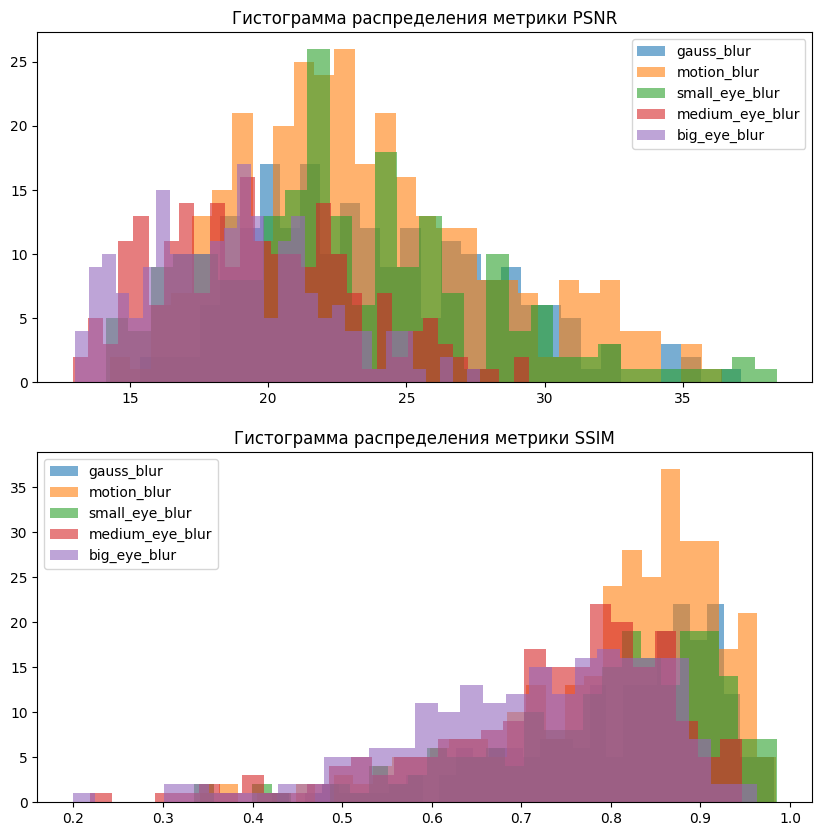

In [61]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

for i, metric_name in zip(range(len(axs)), ['psnr', 'ssim']):
    for blur_type in metrics.keys():
        axs[i].hist(metrics[blur_type][metric_name], label=blur_type, bins=30, alpha=0.6)
    axs[i].legend()
    axs[i].set_title(f'Гистограмма распределения метрики {metric_name.upper()}')

Средние и СКО:

In [6]:
for blur_type in metrics.keys():
    print(blur_type)

    psnr_stats = stats.describe(metrics[blur_type]['psnr'])
    print(f'psnr | mean / std: {psnr_stats.mean:.4f} / {psnr_stats.variance ** 0.5:.4f}; min-max: {psnr_stats.minmax}')

    ssim_stats = stats.describe(metrics[blur_type]['ssim'])
    print(f'ssim | mean / std: {ssim_stats.mean:.4f} / {ssim_stats.variance ** 0.5:.4f}; min-max: {ssim_stats.minmax}')
    print()

gauss_blur
psnr | mean / std: 23.9129 / 4.3690; min-max: (15.364728523229632, 37.10979814092341)
ssim | mean / std: 0.8129 / 0.1146; min-max: (0.42166785784952154, 0.9818222732056389)

motion_blur
psnr | mean / std: 23.5747 / 4.5509; min-max: (14.287301023369869, 36.41456360353609)
ssim | mean / std: 0.8056 / 0.1220; min-max: (0.34092253034761233, 0.9845391364219598)

small_eye_blur
psnr | mean / std: 22.8789 / 4.8939; min-max: (14.144223258508813, 38.40715738726519)
ssim | mean / std: 0.7947 / 0.1294; min-max: (0.3347042621553864, 0.985602278528804)

medium_eye_blur
psnr | mean / std: 19.5776 / 3.5359; min-max: (12.931258779844034, 29.44787874531591)
ssim | mean / std: 0.7317 / 0.1382; min-max: (0.21857764551226777, 0.9460094472515295)

big_eye_blur
psnr | mean / std: 18.6399 / 3.1154; min-max: (13.03422491749159, 27.667130206851553)
ssim | mean / std: 0.7114 / 0.1393; min-max: (0.19903014622408063, 0.9632875505871187)



Тест Манна-Уитни о равенстве мат.ожидания выборочному среднему:

In [7]:
print('gauss_blur')
print(stats.mannwhitneyu(metrics['gauss_blur']['psnr'], 23.9))
print(stats.mannwhitneyu(metrics['gauss_blur']['ssim'], 0.81))
print()

print('motion_blur')
print(stats.mannwhitneyu(metrics['motion_blur']['psnr'], 23.6))
print(stats.mannwhitneyu(metrics['motion_blur']['ssim'], 0.81))
print()

print('small_eye_blur')
print(stats.mannwhitneyu(metrics['small_eye_blur']['psnr'], 22.9))
print(stats.mannwhitneyu(metrics['small_eye_blur']['ssim'], 0.79))
print()

print('medium_eye_blur')
print(stats.mannwhitneyu(metrics['medium_eye_blur']['psnr'], 19.6))
print(stats.mannwhitneyu(metrics['medium_eye_blur']['ssim'],  0.73))
print()

print('big_eye_blur')
print(stats.mannwhitneyu(metrics['big_eye_blur']['psnr'], 18.6))
print(stats.mannwhitneyu(metrics['big_eye_blur']['ssim'], 0.71))
print()

gauss_blur
MannwhitneyuResult(statistic=93.0, pvalue=0.8909952606635061)
MannwhitneyuResult(statistic=131.0, pvalue=0.7582938388625584)

motion_blur
MannwhitneyuResult(statistic=138.0, pvalue=0.8606811145510818)
MannwhitneyuResult(statistic=197.0, pvalue=0.7801857585139306)

small_eye_blur
MannwhitneyuResult(statistic=93.0, pvalue=0.8909952606635061)
MannwhitneyuResult(statistic=129.0, pvalue=0.7772511848341224)

medium_eye_blur
MannwhitneyuResult(statistic=98.0, pvalue=0.938388625592416)
MannwhitneyuResult(statistic=125.0, pvalue=0.8151658767772503)

big_eye_blur
MannwhitneyuResult(statistic=106.0, pvalue=0.9952606635071078)
MannwhitneyuResult(statistic=119.0, pvalue=0.8720379146919421)



Проверка на нормальный ЗР:

In [8]:
for blur_type in metrics.keys():
    print(blur_type)

    t_statistic, p_value = stats.shapiro(metrics[blur_type]['psnr'])
    print(f'psnr | t_statistic: {t_statistic:.4f}, p-value: {p_value:.4f}')

    t_statistic, p_value = stats.shapiro(metrics[blur_type]['ssim'])
    print(f'ssim | t_statistic: {t_statistic:.4f}, p-value: {p_value:.4f}')

    print()

gauss_blur
psnr | t_statistic: 0.9703, p-value: 0.0002
ssim | t_statistic: 0.9126, p-value: 0.0000

motion_blur
psnr | t_statistic: 0.9697, p-value: 0.0000
ssim | t_statistic: 0.9039, p-value: 0.0000

small_eye_blur
psnr | t_statistic: 0.9680, p-value: 0.0001
ssim | t_statistic: 0.9232, p-value: 0.0000

medium_eye_blur
psnr | t_statistic: 0.9792, p-value: 0.0034
ssim | t_statistic: 0.9221, p-value: 0.0000

big_eye_blur
psnr | t_statistic: 0.9802, p-value: 0.0047
ssim | t_statistic: 0.9523, p-value: 0.0000



Визуализация

In [9]:
image_path = 'datasets/gt/precomp/texts/_10_1.jpg'

image = imread(image_path)

if image_path.endswith('.jpg'):  # sRGB 8 bit
    image = uint8_to_float32(image)  # sRGB float

if image.ndim == 3:
    image = srgb2gray(image)  # sRGB float

image = srgbf_to_linrgbf(image)  # linRGB float


In [10]:
kernels = {
    'gauss_blur': load_npy('datasets/kernels/gauss-blur/processed/synthetic/synthetic-0.npy', key='psf'),
    'motion_blur': load_npy('datasets/kernels/motion-blur/processed/synthetic/synthetic-16.npy', key='psf'),
    'small_eye_blur': load_npy('datasets/kernels/eye-psf/processed/synthetic/small-psf-0.npy', key='psf'),
    'medium_eye_blur': load_npy('datasets/kernels/eye-psf/processed/synthetic/medium-psf-0.npy', key='psf'),
    'big_eye_blur': load_npy('datasets/kernels/eye-psf/processed/synthetic/big-psf-0.npy', key='psf'),
}

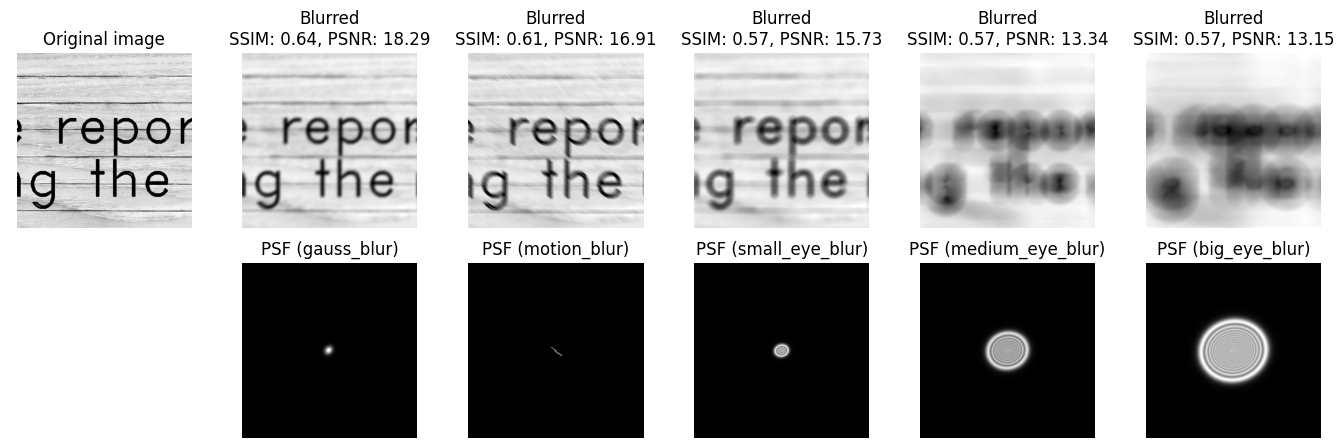

In [11]:
fig, axs = plt.subplots(2, 6, figsize=(17, 5))

[axi.set_axis_off() for axi in axs.ravel()]

axs[0, 0].imshow(image)
axs[0, 0].set_title('Original image')

for i, (kernel_type, kernel) in enumerate(kernels.items()):
    blurred = convolve(image, kernel).astype(np.float32)
    axs[0, i + 1].imshow(blurred)
    axs[0, i + 1].set_title(f'Blurred\nSSIM: {ssim(image, blurred):.2f}, PSNR: {psnr(image, blurred):.2f}')
    axs[1, i + 1].imshow(pad_to_shape(kernel, (256, 256)))
    axs[1, i + 1].set_title(f'PSF ({kernel_type})')

Увеличение площади контура PSF

Гаусс

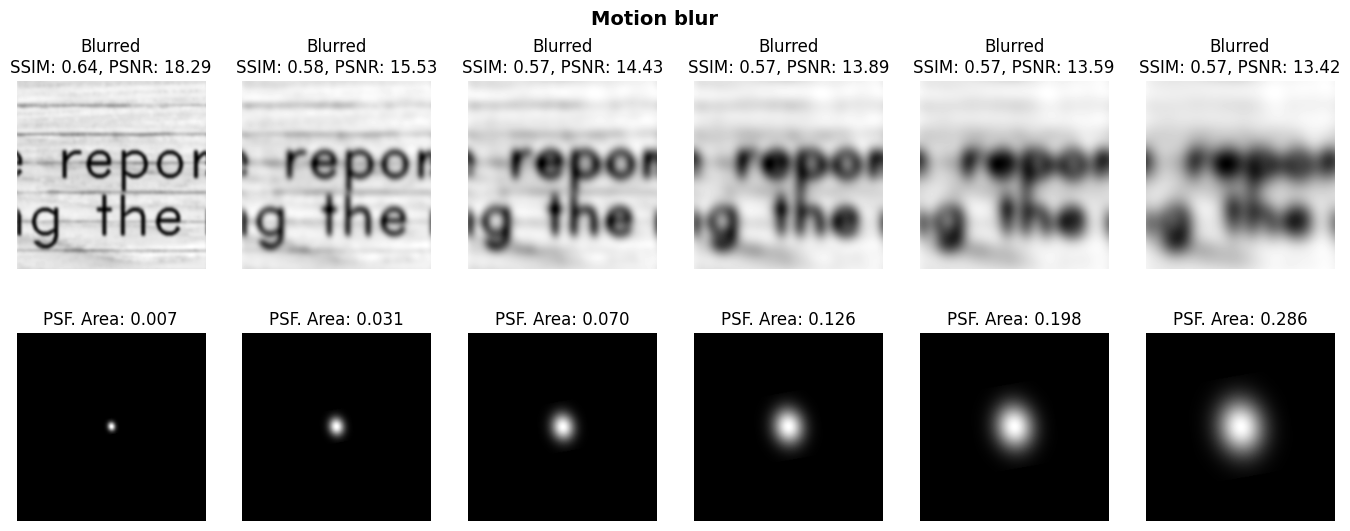

In [57]:
fig, axs = plt.subplots(2, 6, figsize=(17, 6))
fig.suptitle('Motion blur', fontsize=14, fontweight='black')

[axi.set_axis_off() for axi in axs.ravel()]

for i in range(1, 7):
    psf = generate_gauss_kernel(sigmax=6 * i, sigmay=5 * i, size=(3, 3), angle=10)

    blurred = convolve(image, psf).astype(np.float32)
    axs[0, i-1].imshow(blurred)
    axs[0, i-1].set_title(f'Blurred\nSSIM: {ssim(image, blurred):.2f}, PSNR: {psnr(image, blurred):.2f}')

    if psf.shape[0] < 256 and psf.shape[1] < 256:
        psf = pad_to_shape(psf, (256, 256))
    axs[1, i-1].imshow(pad_to_shape(psf, (256, 256)))
    axs[1, i-1].set_title(f'PSF. Area: {len(psf[psf > 0]) / len(psf.ravel()):.3f}')

Motion blur

In [13]:
kernel = load_npy('datasets/kernels/motion-blur/processed/Levin/levin-0.npy', key='psf')
kernel.shape

(19, 19)

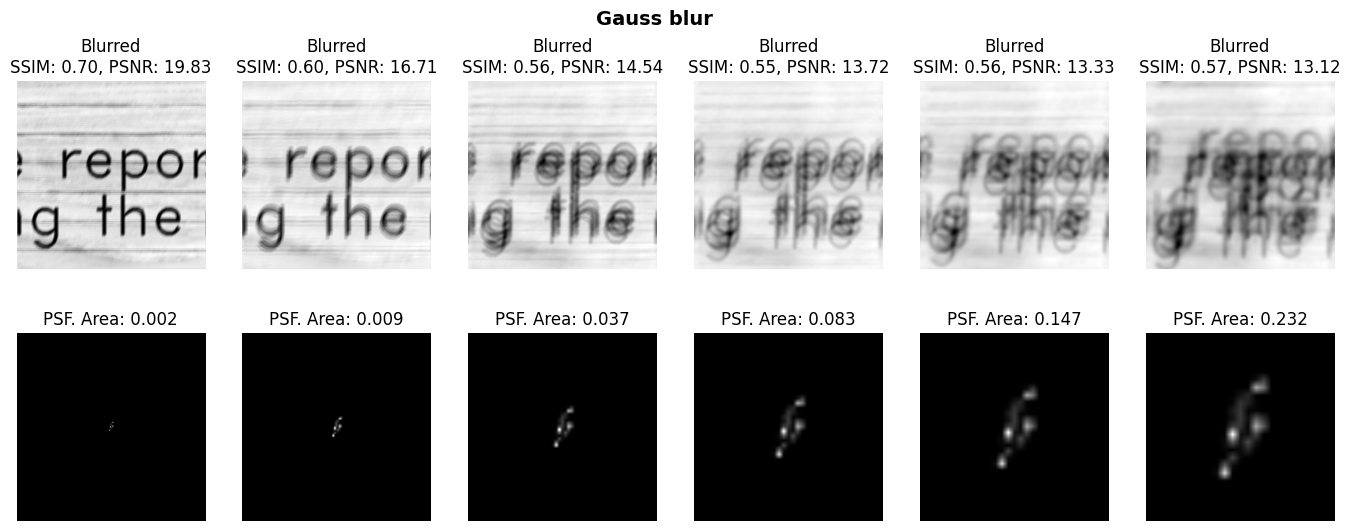

In [56]:
fig, axs = plt.subplots(2, 6, figsize=(17, 6))
[axi.set_axis_off() for axi in axs.ravel()]
fig.suptitle('Gauss blur', fontsize=14, fontweight='black')

for i in range(6):
    if i == 0:
        psf = kernel.copy()
    else:
        psf = cv2.resize(kernel, (40 * i, 40 * i))
        psf = psf / psf.sum()
    
    blurred = convolve(image, psf).astype(np.float32)
    axs[0, i].imshow(blurred)
    axs[0, i].set_title(f'Blurred\nSSIM: {ssim(image, blurred):.2f}, PSNR: {psnr(image, blurred):.2f}')

    if psf.shape[0] < 256 and psf.shape[1] < 256:
        psf = pad_to_shape(psf, (256, 256))
    axs[1, i].imshow(pad_to_shape(psf, (256, 256)))
    axs[1, i].set_title(f'PSF. Area: {len(psf[psf > 0]) / len(psf.ravel()):.3f}')

### Зависимость силы размытия от размера ядра

In [27]:
def generate_samples(image: np.ndarray, kernels_dir: str, num_kernels: int, num_iter: int = 11) -> tp.Tuple[tp.List[int], tp.List[float], tp.List[float]]:
    psfs = list(Path(kernels_dir).rglob('*.npy'))
    psfs = [load_npy(psf_path, key='psf') for psf_path in psfs[:num_kernels]]

    kernel_sizes = []
    psnrs = []
    ssims = []

    for kernel in tqdm(psfs):
        for i in range(num_iter):
            if i == 0:
                psf = kernel.copy()
                kernel_size = psf.shape[0]
            else:
                kernel_size = kernel.shape[0] + 20 * i
                psf = cv2.resize(kernel, (kernel_size, kernel_size))
                psf = psf / psf.sum()
            
            blurred = convolve(image, psf).astype(np.float32)
            psnrs.append(psnr(image, blurred))
            ssims.append(ssim(image, blurred))
            kernel_sizes.append(kernel_size)
    return kernel_sizes, psnrs, ssims

In [28]:
motion_kernel_sizes, motion_psnrs, motion_ssims = generate_samples(image, 'datasets/kernels/motion-blur/processed/Levin/', 8, num_iter=12)
gauss_kernel_sizes, gauss_psnrs, gauss_ssims = generate_samples(image, 'datasets/kernels/gauss-blur/processed/synthetic/', 8, num_iter=11)

100%|██████████| 8/8 [00:01<00:00,  4.42it/s]


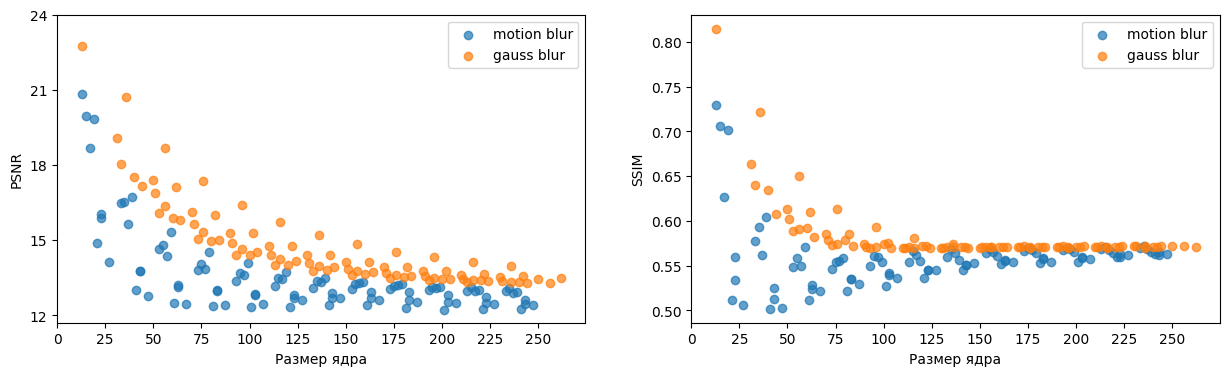

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].scatter(motion_kernel_sizes, motion_psnrs, alpha=0.7, label='motion blur')
axs[0].scatter(gauss_kernel_sizes, gauss_psnrs, alpha=0.7, label='gauss blur')
axs[0].set_xlabel('Размер ядра')
axs[0].set_xticks(np.arange(0, 251, 25))
axs[0].set_yticks(np.arange(12, 25, 3))
axs[0].set_ylabel('PSNR')
axs[0].legend()

axs[1].scatter(motion_kernel_sizes, motion_ssims, alpha=0.7, label='motion blur')
axs[1].scatter(gauss_kernel_sizes, gauss_ssims, alpha=0.7, label='gauss blur')
axs[1].set_xlabel('Размер ядра')
axs[1].set_xticks(np.arange(0, 251, 25))
axs[1].set_ylabel('SSIM')
axs[1].legend()


## 2 Эксперимент: Метрики Винеровского фильтра и USRNet

In [2]:
%load_ext sql

In [3]:
%sql sqlite:////home/chaganovaob/edu/non-blind-deconvolution-benchmark/results/metrics.db

'Connected: @/home/chaganovaob/edu/non-blind-deconvolution-benchmark/results/metrics.db'

#### sql start

In [4]:
%%sql sqlite://

DROP VIEW IF EXISTS metrics;

CREATE VIEW metrics AS 
    SELECT model, blur_type || '_big' AS 'blur_type', ROUND(AVG(psnr), 4) AS AVG_psnr, ROUND(AVG(ssim), 4) as 'AVG_ssim'
    FROM main_25_04
    WHERE discretization == 'linrgb_float' AND noised == False AND model in ('usrnet', 'wiener_nonblind_noise') AND blur_type == 'eye_blur'
    AND kernel LIKE '%big%'
    GROUP BY model, blur_type

    UNION

    SELECT model, blur_type || '_medium' AS 'blur_type', ROUND(AVG(psnr), 4) AS AVG_psnr, ROUND(AVG(ssim), 4) as 'AVG_ssim'
    FROM main_25_04
    WHERE discretization == 'linrgb_float' AND noised == False AND model in ('usrnet', 'wiener_nonblind_noise')  AND blur_type == 'eye_blur'
    AND kernel LIKE '%medium%'
    GROUP BY model, blur_type

    UNION

    SELECT model, blur_type || '_small' AS 'blur_type', ROUND(AVG(psnr), 4) AS AVG_psnr, ROUND(AVG(ssim), 4) as 'AVG_ssim'
    FROM main_25_04
    WHERE discretization == 'linrgb_float' AND noised == False AND model in ('usrnet', 'wiener_nonblind_noise')  AND blur_type == 'eye_blur'
    AND kernel LIKE '%small%'
    GROUP BY model, blur_type

    UNION

    SELECT model, blur_type, ROUND(AVG(psnr), 4) AS AVG_psnr, ROUND(AVG(ssim), 4) as 'AVG_ssim'
    FROM main_25_04
    WHERE discretization == 'linrgb_float' AND noised == False AND model in ('usrnet', 'wiener_nonblind_noise')  AND blur_type != 'eye_blur'
    GROUP BY model, blur_type;


SELECT *
FROM metrics
ORDER BY model, AVG_psnr;



Done.
Done.
Done.


model,blur_type,AVG_psnr,AVG_ssim
usrnet,eye_blur_big,29.5467,0.9025
usrnet,gauss_blur,31.0807,0.9144
usrnet,eye_blur_medium,31.7651,0.923
usrnet,eye_blur_small,36.507,0.9713
usrnet,motion_blur,45.9887,0.9963
wiener_nonblind_noise,gauss_blur,24.7486,0.8776
wiener_nonblind_noise,eye_blur_big,27.8115,0.9323
wiener_nonblind_noise,eye_blur_medium,30.2168,0.9503
wiener_nonblind_noise,eye_blur_small,34.7736,0.9532
wiener_nonblind_noise,motion_blur,44.855,0.9595


In [40]:
%%sql sqlite://

DROP VIEW IF EXISTS metrics;

CREATE VIEW metrics AS 
    SELECT model, blur_type || '_big' AS 'blur_type', ROUND(AVG(psnr), 4) AS AVG_psnr, ROUND(AVG(ssim), 4) as 'AVG_ssim'
    FROM main_25_04
    WHERE discretization == 'srgb_8bit' AND noised == False AND model in ('usrnet', 'wiener_nonblind_noise') AND blur_type == 'eye_blur'
    AND kernel LIKE '%big%'
    GROUP BY model, blur_type

    UNION

    SELECT model, blur_type || '_medium' AS 'blur_type', ROUND(AVG(psnr), 4) AS AVG_psnr, ROUND(AVG(ssim), 4) as 'AVG_ssim'
    FROM main_25_04
    WHERE discretization == 'srgb_8bit' AND noised == False AND model in ('usrnet', 'wiener_nonblind_noise')  AND blur_type == 'eye_blur'
    AND kernel LIKE '%medium%'
    GROUP BY model, blur_type

    UNION

    SELECT model, blur_type || '_small' AS 'blur_type', ROUND(AVG(psnr), 4) AS AVG_psnr, ROUND(AVG(ssim), 4) as 'AVG_ssim'
    FROM main_25_04
    WHERE discretization == 'srgb_8bit' AND noised == False AND model in ('usrnet', 'wiener_nonblind_noise')  AND blur_type == 'eye_blur'
    AND kernel LIKE '%small%'
    GROUP BY model, blur_type

    UNION

    SELECT model, blur_type, ROUND(AVG(psnr), 4) AS AVG_psnr, ROUND(AVG(ssim), 4) as 'AVG_ssim'
    FROM main_25_04
    WHERE discretization == 'srgb_8bit' AND noised == False AND model in ('usrnet', 'wiener_nonblind_noise')  AND blur_type != 'eye_blur'
    GROUP BY model, blur_type;


SELECT *
FROM metrics
ORDER BY model, AVG_psnr;


Done.
Done.
Done.


model,blur_type,AVG_psnr,AVG_ssim
usrnet,eye_blur_big,21.8074,0.6472
usrnet,eye_blur_medium,24.4002,0.7316
usrnet,gauss_blur,27.8015,0.8558
usrnet,eye_blur_small,29.356,0.8542
usrnet,motion_blur,38.7382,0.9872
wiener_nonblind_noise,eye_blur_big,17.6203,0.6779
wiener_nonblind_noise,eye_blur_medium,18.5207,0.7105
wiener_nonblind_noise,eye_blur_small,20.2584,0.8084
wiener_nonblind_noise,gauss_blur,20.4843,0.8014
wiener_nonblind_noise,motion_blur,23.3659,0.9159


#### sql end

### Почему Винер так сильно отстает на gauss blur?

In [61]:
%%sql sqlite://

SELECT model, blur_type, noised, kernel, image, ssim, psnr
FROM main_25_04
WHERE discretization == 'linrgb_float' and model == 'wiener_nonblind_noise' AND noised==False AND blur_type == 'motion_blur'
ORDER BY psnr, ssim
LIMIT 5;

Done.


model,blur_type,noised,kernel,image,ssim,psnr
wiener_nonblind_noise,motion_blur,0,datasets/kernels/motion-blur/processed/synthetic/synthetic-27.npy,datasets/gt/precomp/nature/1 (39).jpg,0.3962653226041794,8.518373127216858
wiener_nonblind_noise,motion_blur,0,datasets/kernels/motion-blur/processed/synthetic/synthetic-3.npy,datasets/gt/precomp/nature/1 (36).jpg,0.5521234111590385,8.604808337910391
wiener_nonblind_noise,motion_blur,0,datasets/kernels/motion-blur/processed/Levin/levin-1.npy,datasets/gt/precomp/animals/1 (65).jpg,0.17709366703629495,10.051219799096266
wiener_nonblind_noise,motion_blur,0,datasets/kernels/motion-blur/processed/synthetic/synthetic-17.npy,datasets/gt/precomp/nature/1 (35).jpg,0.8957623427677155,10.534734727472053
wiener_nonblind_noise,motion_blur,0,datasets/kernels/motion-blur/processed/Sun/sun-5.npy,datasets/gt/precomp/city/01 (28).jpg,0.6328082757625579,10.691822125239117


In [60]:
%%sql sqlite://

SELECT model, blur_type, noised, kernel, image, ssim, psnr
FROM main_25_04
WHERE discretization == 'linrgb_float' and model == 'dwdn' AND noised==False AND blur_type == 'motion_blur'
ORDER BY psnr, ssim
LIMIT 5;

Done.


model,blur_type,noised,kernel,image,ssim,psnr
dwdn,motion_blur,0,datasets/kernels/motion-blur/processed/synthetic/synthetic-6.npy,datasets/gt/precomp/nature/1 (55).jpg,0.9198202226890959,23.563115021031628
dwdn,motion_blur,0,datasets/kernels/motion-blur/processed/synthetic/synthetic-3.npy,datasets/gt/precomp/city/01 (4).jpg,0.9294541901609897,24.47729981727834
dwdn,motion_blur,0,datasets/kernels/motion-blur/processed/synthetic/synthetic-23.npy,datasets/gt/precomp/texts/_texts__1_8.jpg,0.9366925560190678,24.698880175781564
dwdn,motion_blur,0,datasets/kernels/motion-blur/processed/synthetic/synthetic-9.npy,datasets/gt/precomp/texts/_texts__3_2.jpg,0.8961945635632426,24.903242392841896
dwdn,motion_blur,0,datasets/kernels/motion-blur/processed/synthetic/synthetic-26.npy,datasets/gt/precomp/texts/_texts__1_5.jpg,0.908747599421978,25.047596768524304


In [62]:
%%sql sqlite://

SELECT blur_type, noised, kernel, image, ssim, psnr
FROM main_25_04
WHERE discretization == 'linrgb_float' and model == 'wiener_nonblind_noise' AND noised==False
ORDER BY psnr, ssim
LIMIT 10;

Done.


blur_type,noised,kernel,image,ssim,psnr
gauss_blur,0,datasets/kernels/gauss-blur/processed/synthetic/synthetic-4.npy,datasets/gt/precomp/city/01 (16).jpg,0.624434590391159,5.015562156622502
gauss_blur,0,datasets/kernels/gauss-blur/processed/synthetic/synthetic-27.npy,datasets/gt/precomp/nature/1 (98).jpg,0.5210017314956188,5.566088101996657
eye_blur,0,datasets/kernels/eye-psf/processed/synthetic/big-psf-18.npy,datasets/gt/precomp/city/01 (16).jpg,0.6575222174491883,5.98424154563798
gauss_blur,0,datasets/kernels/gauss-blur/processed/synthetic/synthetic-12.npy,datasets/gt/precomp/nature/1 (100).jpg,0.7588899296512603,6.587915797951892
eye_blur,0,datasets/kernels/eye-psf/processed/synthetic/small-psf-11.npy,datasets/gt/precomp/nature/1 (100).jpg,0.7723803588104248,7.048143592774355
gauss_blur,0,datasets/kernels/gauss-blur/processed/synthetic/synthetic-13.npy,datasets/gt/precomp/nature/1 (93).jpg,0.5969044503573179,7.302615387524566
eye_blur,0,datasets/kernels/eye-psf/processed/synthetic/big-psf-6.npy,datasets/gt/precomp/nature/1 (39).jpg,0.38317715008449554,8.035034439686985
motion_blur,0,datasets/kernels/motion-blur/processed/synthetic/synthetic-27.npy,datasets/gt/precomp/nature/1 (39).jpg,0.3962653226041794,8.518373127216858
eye_blur,0,datasets/kernels/eye-psf/processed/synthetic/small-psf-25.npy,datasets/gt/precomp/nature/1 (36).jpg,0.5502797353386879,8.534940794022763
motion_blur,0,datasets/kernels/motion-blur/processed/synthetic/synthetic-3.npy,datasets/gt/precomp/nature/1 (36).jpg,0.5521234111590385,8.604808337910391


In [20]:
def _1d_t0_3d(image: np.ndarray) -> np.ndarray:
    return np.dstack([image for _ in range(3)])

In [27]:
def viz(image_path: str, kernel_path: str, **wiener_parms) -> tp.Tuple[np.ndarray, np.ndarray]:
    image = imread(image_path)
    image = center_crop(image, 256, 256)

    if image_path.endswith('.jpg'):  # sRGB 8 bit
        image = uint8_to_float32(image)  # sRGB float

    if image.ndim == 3:
        image = srgb2gray(image)  # sRGB float

    image = srgbf_to_linrgbf(image)  # linRGB float

    psf = load_npy(kernel_path, key='psf')

    blurred = convolve(image, psf)
    restored = wiener_gray(blurred, psf, **wiener_parms)

    imsshow([_1d_t0_3d(image), psf, _1d_t0_3d(blurred), _1d_t0_3d(restored), image - restored], (15, 5), ['Image', 'PSF', 'Blurred', 'Restored', 'Diff'])
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 3))
    axs[0].hist(image.ravel(), bins=64) #calculating histogram
    axs[0].set_title(f'Image (max: {image.max():.2f})')
    axs[1].hist(restored.ravel(), bins=64) #calculating histogram
    axs[1].set_title(f'Restored (max: {restored.max():.2f})')
    axs[2].hist(blurred.ravel(), bins=64) #calculating histogram
    axs[2].set_title(f'Blurred (max: {blurred.max():.2f})')
    plt.show()

    print(f'Image-blurred: ssim {ssim(image, blurred):.3f}, psnr {psnr(image, blurred)}')
    print(f'Image-restored: ssim {ssim(image, restored):.3f}, psnr {psnr(image, restored)}')
    return image, restored

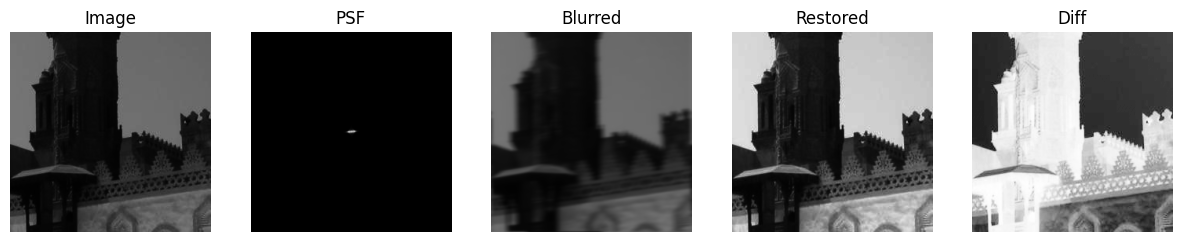

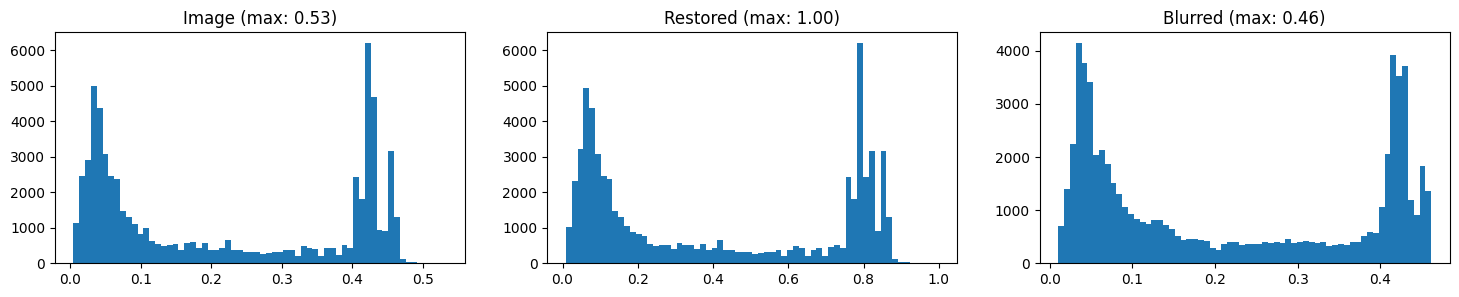

Image-blurred: ssim 0.917, psnr 29.46844740673629
Image-restored: ssim 0.794, psnr 12.244543913684794


In [28]:
image, restored = viz(
    'datasets/gt/Sun-gray/im_48.png',
    'datasets/kernels/eye-psf/processed/synthetic/small-psf-23.npy',
    clip=False,
    balance=1e-8,
)

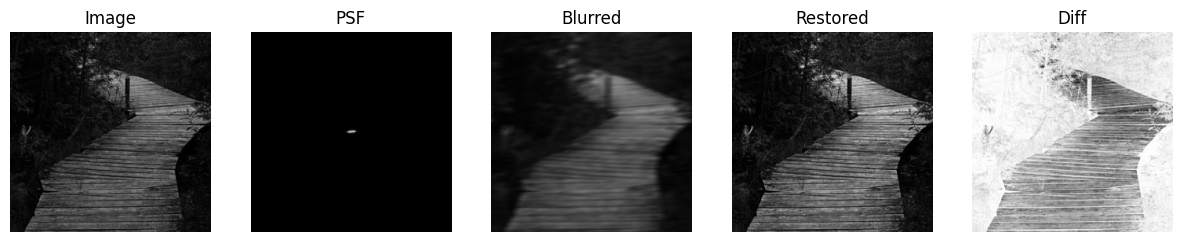

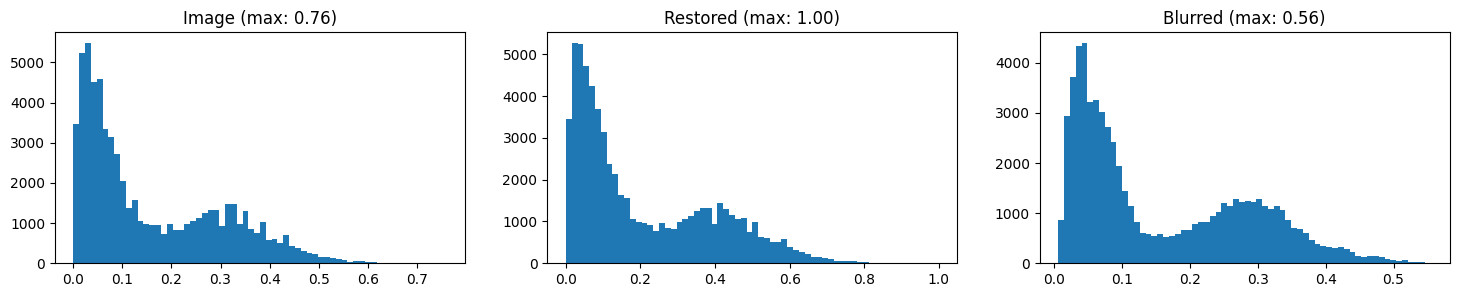

Image-blurred: ssim 0.776, psnr 26.119814021584403
Image-restored: ssim 0.946, psnr 23.500085207163288


In [29]:
image, restored = viz(
    'datasets/gt/Sun-gray/im_8.png',
    'datasets/kernels/eye-psf/processed/synthetic/small-psf-23.npy',
    clip=False,
    balance=1e-8,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


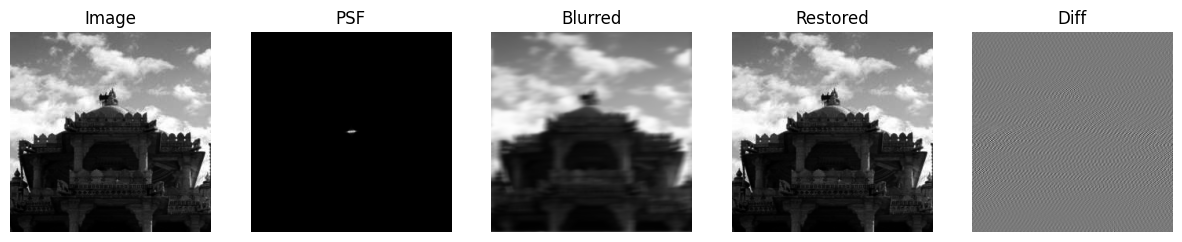

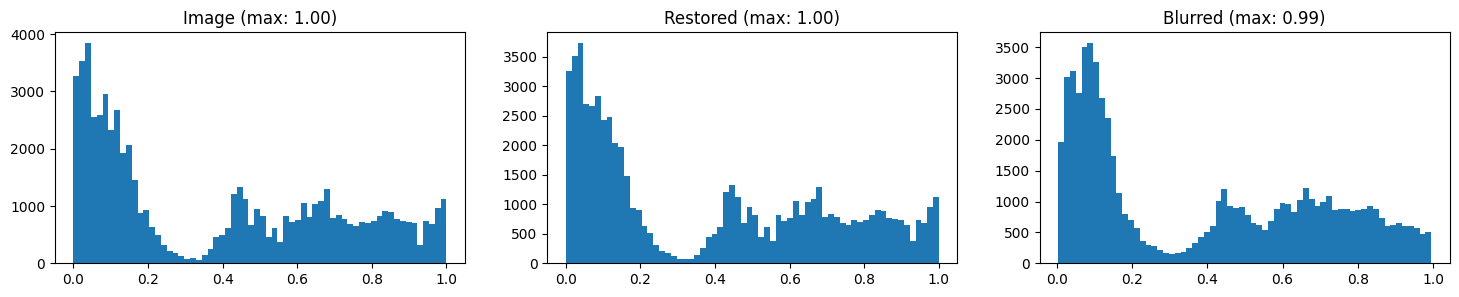

Image-blurred: ssim 0.863, psnr 24.2216160182451
Image-restored: ssim 1.000, psnr 70.78292228067437


In [30]:
image, restored = viz(
    'datasets/gt/Sun-gray/im_64.png',
    'datasets/kernels/eye-psf/processed/synthetic/small-psf-23.npy',
    clip=False,
    balance=1e-8,
)

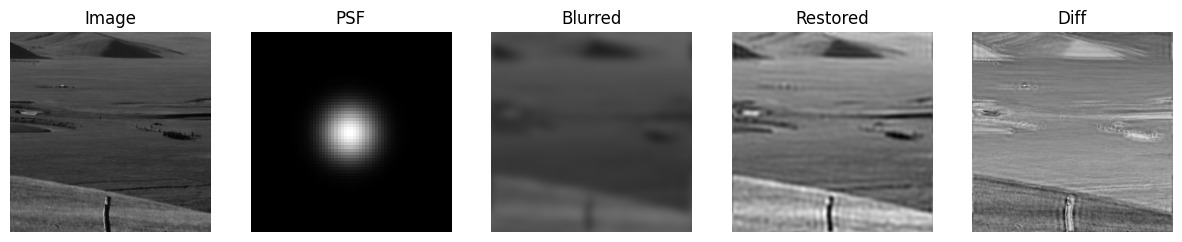

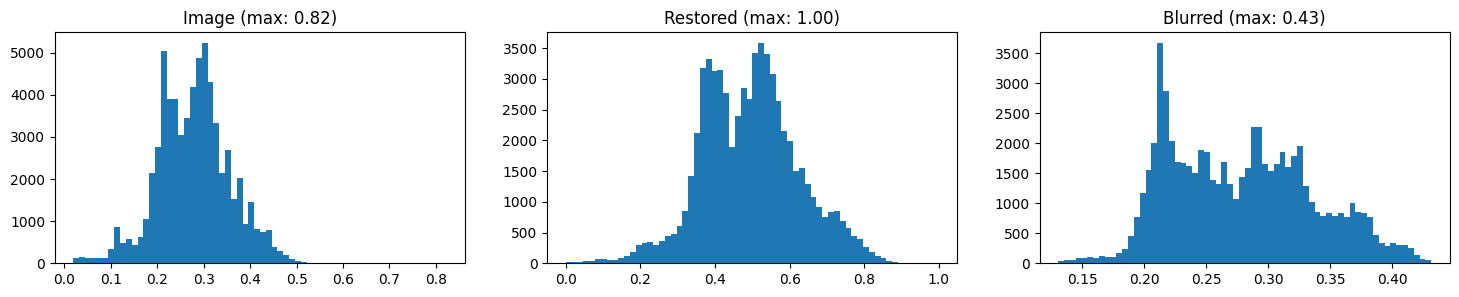

Image-blurred: ssim 0.852, psnr 27.621457628987134
Image-restored: ssim 0.770, psnr 12.993845804988275


In [32]:
image, restored = viz(
    'datasets/gt/Sun-gray/im_29.png',
    'datasets/kernels/gauss-blur/processed/synthetic/synthetic-27.npy',
    clip=True,
    balance=1e-8,
)

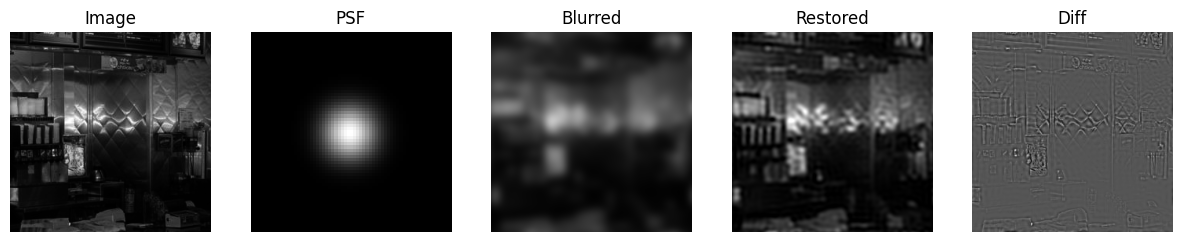

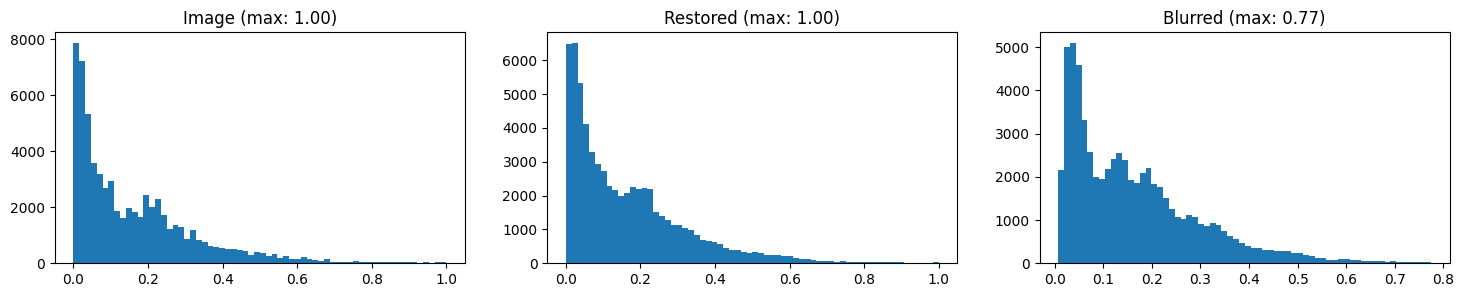

Image-blurred: ssim 0.672, psnr 22.06648844763494
Image-restored: ssim 0.851, psnr 26.304004557316496


In [41]:
image, restored = viz(
    'datasets/gt/Sun-gray/im_28.png',
    'datasets/kernels/gauss-blur/processed/synthetic/synthetic-27.npy',
    clip=True,
    balance=1e-8,
)

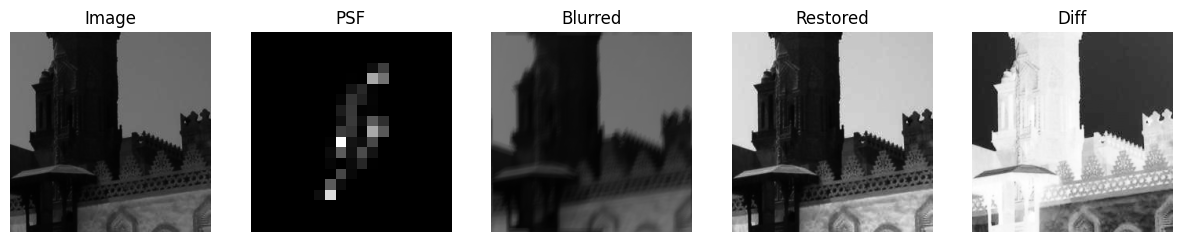

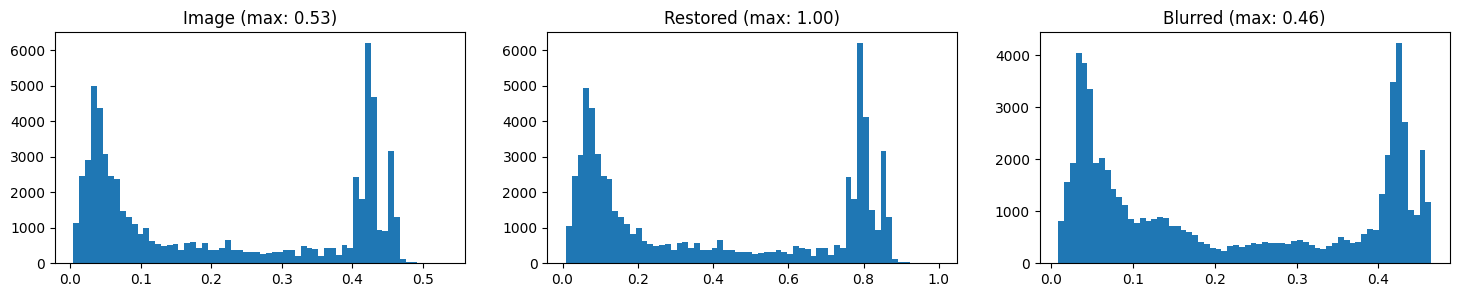

Image-blurred: ssim 0.911, psnr 29.294892593193435
Image-restored: ssim 0.795, psnr 12.267411276973776


In [42]:
image, restored = viz(
    'datasets/gt/Sun-gray/im_48.png',
    'datasets/kernels/motion-blur/processed/Levin/levin-0.npy',
    clip=True,
    balance=1e-8,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


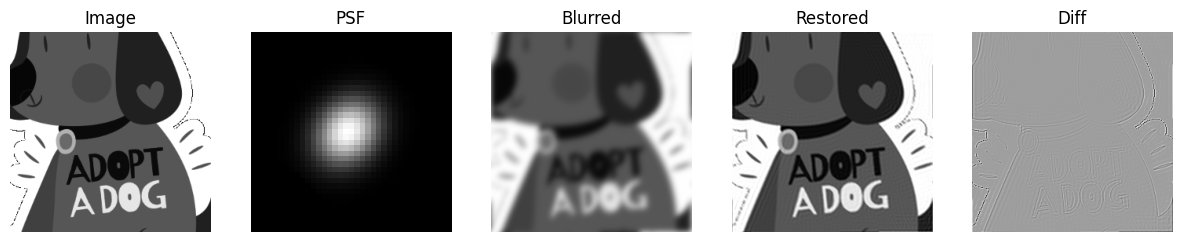

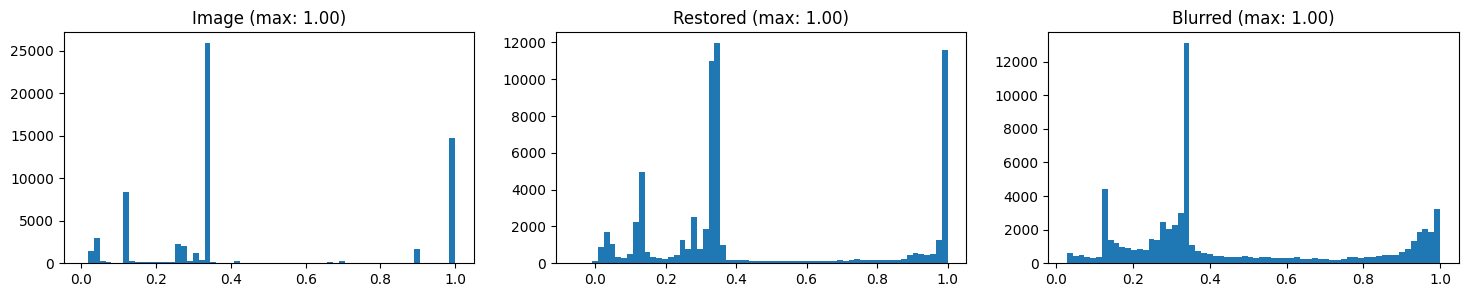

Image-blurred: ssim 0.744, psnr 18.650519031453065
Image-restored: ssim 0.950, psnr 26.37496873362139


In [43]:
image, restored = viz(
    'datasets/gt/precomp/icons_jpg/1/adopt.png',
    'datasets/kernels/gauss-blur/processed/synthetic/synthetic-0.npy',
    clip=False,
    balance=1e-8,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


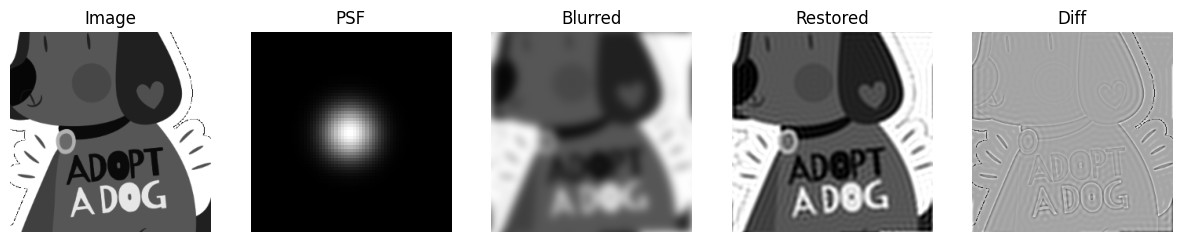

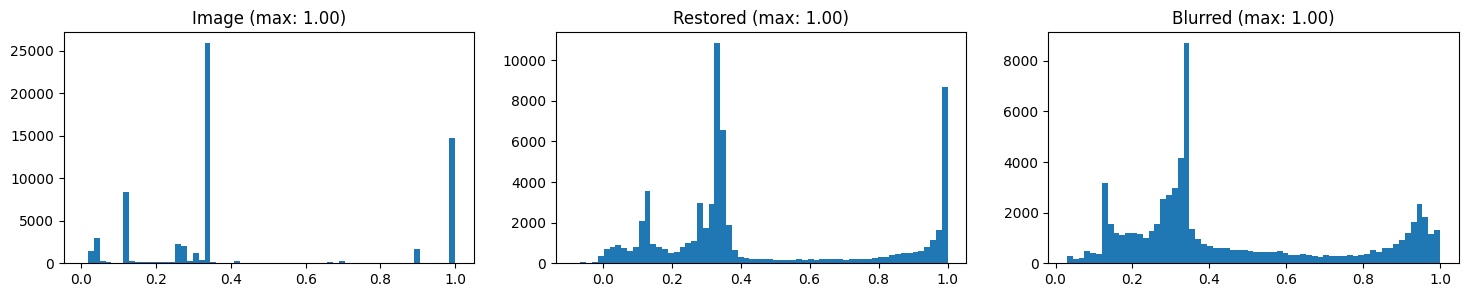

Image-blurred: ssim 0.692, psnr 17.30089932882647
Image-restored: ssim 0.849, psnr 22.31630124789134


In [35]:
image, restored = viz(
    'datasets/gt/precomp/icons_jpg/1/adopt.png',
    'datasets/kernels/gauss-blur/processed/synthetic/synthetic-27.npy',
    clip=False,
    balance=1e-8,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


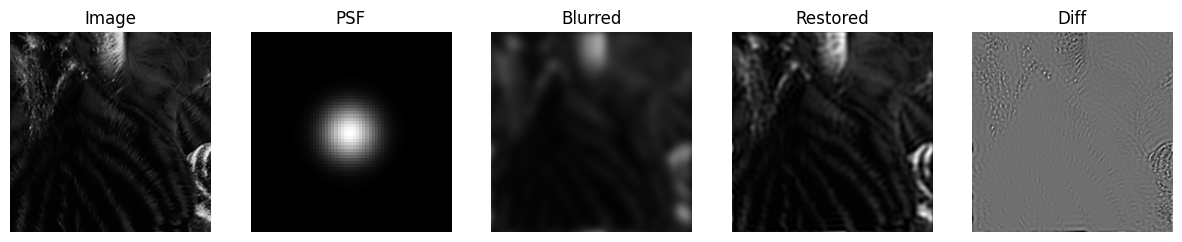

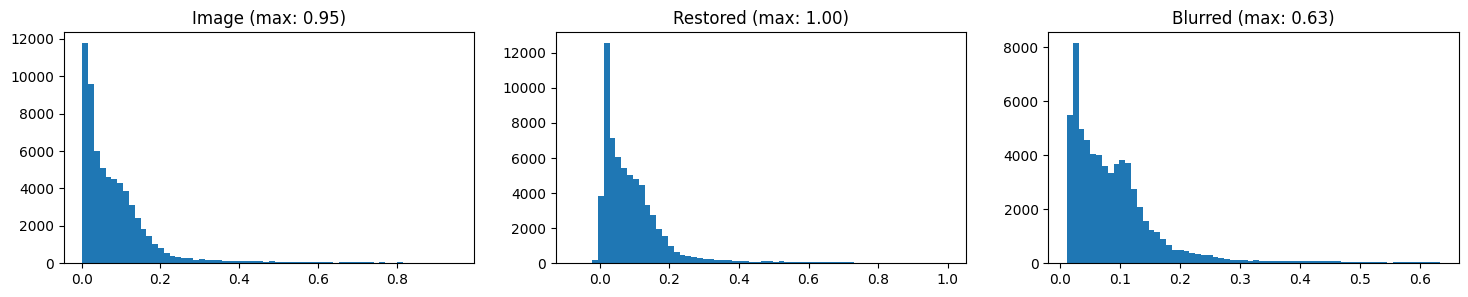

Image-blurred: ssim 0.791, psnr 24.25600553577447
Image-restored: ssim 0.911, psnr 28.921237095194137


In [36]:
image, restored = viz(
    'datasets/gt/precomp/animals/1 (1).jpg',
    'datasets/kernels/gauss-blur/processed/synthetic/synthetic-27.npy',
    clip=False,
    balance=1e-8,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


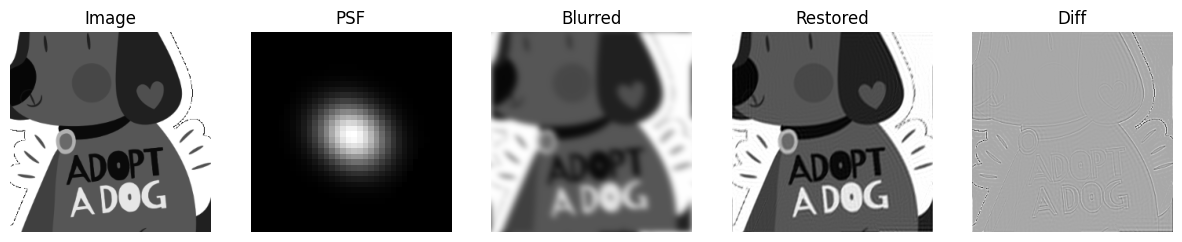

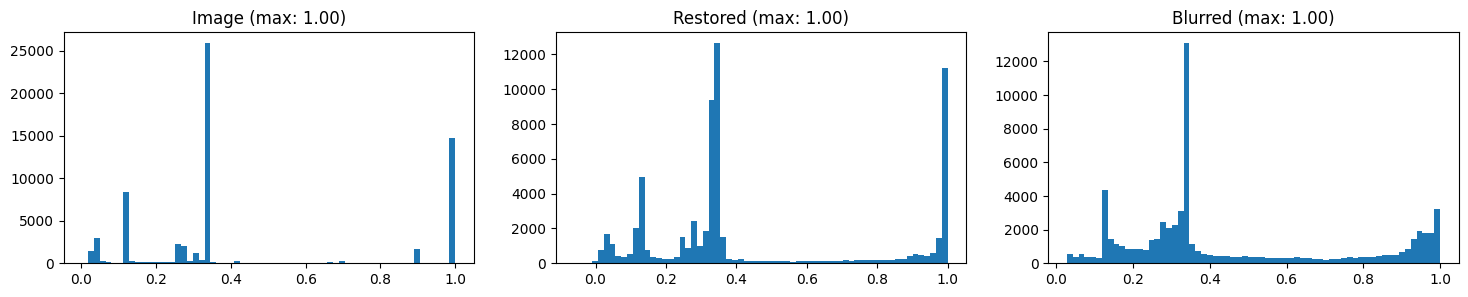

Image-blurred: ssim 0.744, psnr 18.65158349316197
Image-restored: ssim 0.948, psnr 26.411539891105345


In [37]:
image, restored = viz(
    'datasets/gt/precomp/icons_jpg/1/adopt.png',
    'datasets/kernels/gauss-blur/processed/synthetic/synthetic-3.npy',
    clip=False,
    balance=1e-8,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


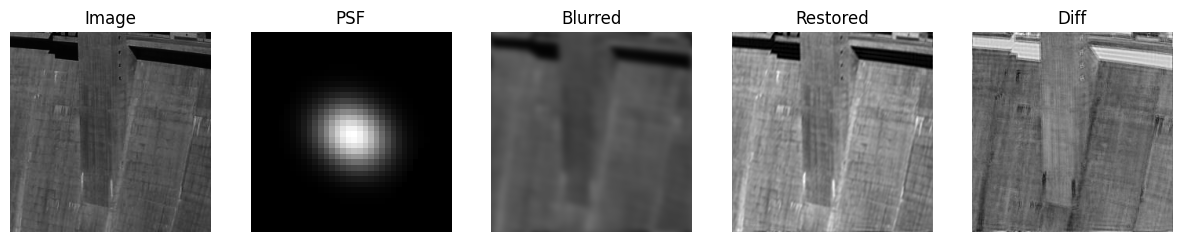

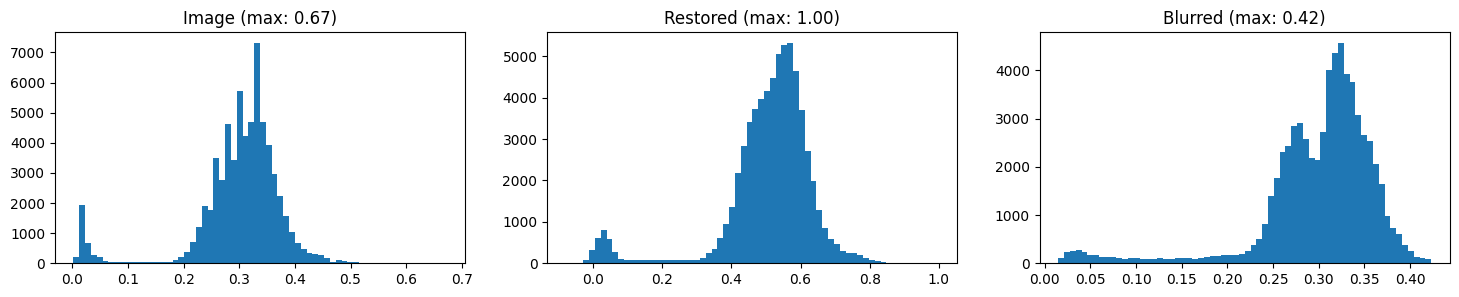

Image-blurred: ssim 0.849, psnr 28.219609353137404
Image-restored: ssim 0.822, psnr 13.317238848637732


In [38]:
image, restored = viz(
    'datasets/gt/Sun-gray/im_26.png',
    'datasets/kernels/gauss-blur/processed/synthetic/synthetic-3.npy',
    clip=False,
    balance=1e-8,
)

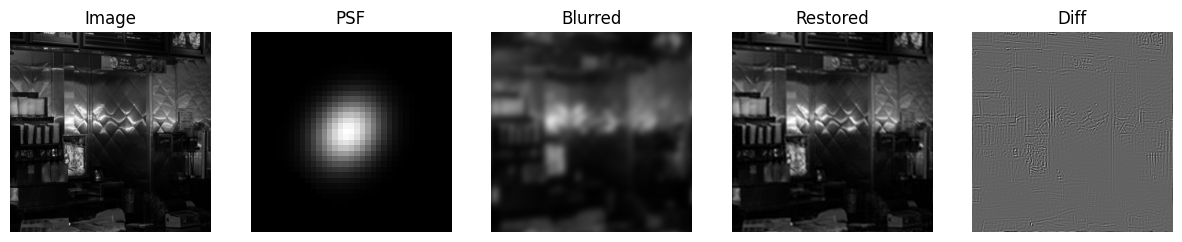

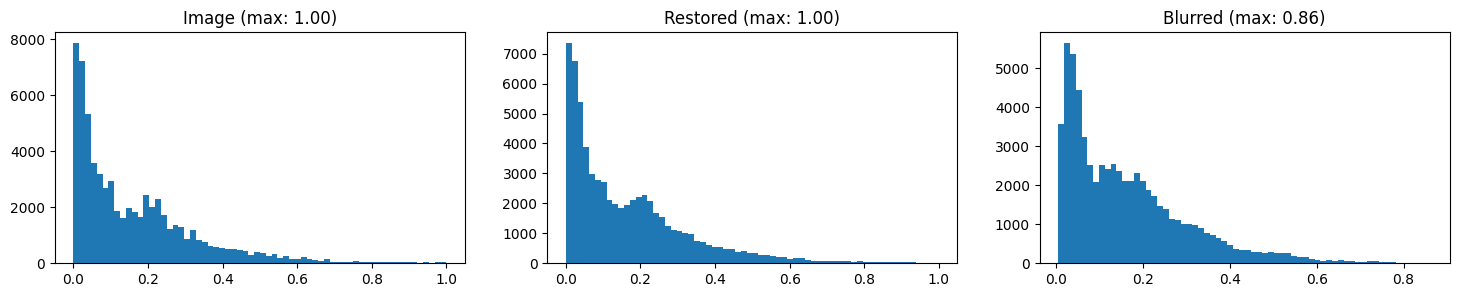

Image-blurred: ssim 0.723, psnr 23.153196421932076
Image-restored: ssim 0.955, psnr 31.1668442717665


In [39]:
image, restored = viz(
    'datasets/gt/Sun-gray/im_28.png',
    'datasets/kernels/gauss-blur/processed/synthetic/synthetic-0.npy',
    clip=True,
    balance=1e-8,
)

### Изотропическое ядро:

In [54]:
%%sql sqlite://

SELECT blur_type, noised, kernel, image, ssim, psnr
FROM main_25_04
WHERE discretization == 'linrgb_float' and model == 'wiener_nonblind_noise' AND noised==False 
AND kernel = 'datasets/kernels/gauss-blur/processed/synthetic/synthetic-27.npy'
ORDER BY psnr, ssim;

Done.


blur_type,noised,kernel,image,ssim,psnr
gauss_blur,0,datasets/kernels/gauss-blur/processed/synthetic/synthetic-27.npy,datasets/gt/precomp/nature/1 (98).jpg,0.5210017314956188,5.566088101996657
gauss_blur,0,datasets/kernels/gauss-blur/processed/synthetic/synthetic-27.npy,datasets/gt/Sun-gray/im_29.png,0.7700162498580218,12.993845804988275
gauss_blur,0,datasets/kernels/gauss-blur/processed/synthetic/synthetic-27.npy,datasets/gt/precomp/icons_jpg/3/ostrich.png,0.7923152215050524,18.92005813274198
gauss_blur,0,datasets/kernels/gauss-blur/processed/synthetic/synthetic-27.npy,datasets/gt/precomp/faces/avatar-fda1c0ac02c3a0255df0fe947173b45c.jpg,0.9195717407112122,18.953680460966346
gauss_blur,0,datasets/kernels/gauss-blur/processed/synthetic/synthetic-27.npy,datasets/gt/precomp/texts/_9_1.jpg,0.849300510161635,22.07314606449978
gauss_blur,0,datasets/kernels/gauss-blur/processed/synthetic/synthetic-27.npy,datasets/gt/precomp/city/01 (1).jpg,0.7628720463819899,22.3320038514698
gauss_blur,0,datasets/kernels/gauss-blur/processed/synthetic/synthetic-27.npy,datasets/gt/precomp/animals/1 (10).jpg,0.888424211695075,22.92433408462404
